In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
from copy import deepcopy
from functools import partial
from io import BytesIO
import json
import os
import warnings
from glob import glob
import sys
import re

In [3]:
import h5py
import igl
import randomcolor
import trimesh
import k3d
import yaml
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from joblib import Parallel, delayed
import trimesh.transformations as tt


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-hz4bbbb6 because the default path (/home/user/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
from sharpf.utils.abc_utils.hdf5.dataset import Hdf5File, PreloadTypes
import sharpf.utils.abc_utils.hdf5.io_struct as io_struct
import sharpf.data.datasets.sharpf_io as sharpf_io
from sharpf.utils.plotting import display_depth_sharpness, plot_views, get_random_color, illustrate_camera
from sharpf.utils.abc_utils.mesh.indexing import reindex_zerobased
from sharpf.utils.abc_utils.mesh.io import trimesh_load
from sharpf.utils.convertor_utils.convertors_io import ViewIO, RangeVisionIO
from sharpf.data.annotation import ANNOTATOR_BY_TYPE
from sharpf.utils.camera_utils.view import CameraView
from sharpf.data.imaging import RaycastingImaging
from sharpf.utils.py_utils.config import load_func_from_config
from sharpf.utils.camera_utils.camera_pose import CameraPose, camera_to_display
from sharpf.utils.abc_utils.hdf5.dataset import Hdf5File, PreloadTypes
from sharpf.utils.abc_utils.mesh.io import trimesh_load
from sharpf.utils.convertor_utils.convertors_io import (
    AnnotatedViewIO,
    ViewIO,
    write_annotated_views_to_hdf5)
from sharpf.utils.abc_utils.abc.feature_utils import (
    compute_features_nbhood,
    remove_boundary_features,
    submesh_from_hit_surfaces)
from sharpf.utils.convertor_utils.meshlab_project_parsers import load_meshlab_project
import sharpf.utils.convertor_utils.rangevision_utils as rv_utils
from sharpf.utils.camera_utils import matrix

from sharpf.utils.numpy_utils.transformations import transform_to_frame


In [5]:
def display_sharpness(mesh=None, plot_meshvert=True,
                      samples=None, samples_distances=None,
                      sharp_vert=None, sharp_curves=None,
                      directions=None, directions_width=0.0025,
                      samples_color=0x0000ff, samples_psize=0.002, 
                      mesh_color=0xbbbbbb, meshvert_color=0x666666, meshvert_psize=0.0025,
                      sharpvert_color=0xff0000, sharpvert_psize=0.0025,
                      sharpcurve_color=None, sharpcurve_width=0.0025,
                      as_image=False, plot_height=768,
                      cmap=k3d.colormaps.matplotlib_color_maps.coolwarm_r, 
                      plot=None, display=True,
                     max_distance_to_feature=1.0):
    
    if None is plot:
        plot = k3d.plot(height=plot_height, camera_auto_fit=True)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(mesh.vertices, mesh.faces, color=mesh_color)
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(mesh.vertices, 
                                    point_size=meshvert_psize, color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='flat'

    if None is not samples:
        colors = None
        if None is not samples_distances and not np.all(samples_distances == 1.0):
            colors = k3d.helpers.map_colors(
                samples_distances, cmap, [0, max_distance_to_feature]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
        else:
            v = -np.array([0., 1., 0.])
            max_dist = np.max(np.dot(samples, v))
            min_dist = np.min(np.dot(samples, v))
            colors = k3d.helpers.map_colors(
                np.dot(samples, v), k3d.colormaps.matplotlib_color_maps.viridis, [min_dist, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)

        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not directions:
            colors = k3d.helpers.map_colors(
                samples_distances, cmap, [0, max_distance_to_feature]
            ).astype(np.uint32)
            colors = [(c, c) for c in colors]

            vectors = k3d.vectors(
                samples,
                directions * samples_distances[..., np.newaxis],
                use_head=False, 
                line_width=directions_width,
                colors=colors)
#             print(vectors)
            plot += vectors

#             directions_to_plot = np.hstack((samples, samples + directions))
            
#             for i, dir_to_plot in enumerate(directions_to_plot):
#                 dir_to_plot = dir_to_plot.reshape((2, 3))
#                 if np.all(dir_to_plot[0] == dir_to_plot[1]):
#                     continue
#                 color = int(colors[i]) if None is not colors else samples_color
#                 plt_line = k3d.line(dir_to_plot, 
#                                     shader='mesh', width=directions_width, color=color)
#                 plot += plt_line

    if None is not sharp_vert:
        k3d_points = k3d.points(sharp_vert,
                                point_size=sharpvert_psize, color=sharpvert_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not sharp_curves:            
            if None is not sharpcurve_color:
                color = sharpcurve_color
            else:
                import randomcolor
                rand_color = randomcolor.RandomColor()
            for i, vert_ind in enumerate(sharp_curves):
                sharp_points_curve = mesh.vertices[vert_ind]
                
                if None is sharpcurve_color:
                    color = rand_color.generate(hue='red')[0]
                    color = int('0x' + color[1:], 16)
                plt_line = k3d.line(sharp_points_curve, 
                                    shader='mesh', width=sharpcurve_width, color=color)
                plot += plt_line
        
    plot.grid_visible = False
    if display:
        plot.display()
    
    if as_image:
        plot.fetch_screenshot()
        return Image(data=b64decode(plot.screenshot))
    
    return plot

In [6]:
def convert_to_fusion_compatible_io(
    input_dataset_filename,
    output_dataset_filename,
):
    input_dataset = Hdf5File(
        input_dataset_filename,
        io=AnnotatedViewIO,
        preload=PreloadTypes.LAZY,
        labels='*')
    
    patches = [{
        'image': image['points'], 
        'distances': image['distances'],
        'camera_pose': image['extrinsics']
    } for image in input_dataset]

    schema_datasets = {
        'image': io_struct.Float64('image'),
        'distances': io_struct.Float64('distances'),
        'camera_pose': io_struct.Float64('camera_pose'),
    }
    WholeDepthMapIO = io_struct.HDF5IO(
        schema_datasets,
        len_label='image',
        compression='lzf')
    def save_whole_images(filename, patches):
        collate_fn = partial(io_struct.collate_mapping_with_io, io=WholeDepthMapIO)
        patches = collate_fn(patches)
        with h5py.File(filename, 'w') as f:
            for key in ['image', 'distances', 'camera_pose']:
                WholeDepthMapIO.write(f, key, patches[key].numpy())

    save_whole_images(output_dataset_filename, patches)
        
    print(output_dataset_filename)

In [7]:
# convert_to_fusion_compatible_io(
#     '/logs/synth_sharpf_scans/6side_folder_preprocessed_synth.hdf5',
#     '/logs/synth_sharpf_scans/6side_folder_preprocessed_synth_io.hdf5'
# )

In [8]:
def sharpness_with_depth_background(
        sharpness_image,
        depth_image,
        depth_bg_value=1.0,
        sharpness_bg_value=0.0,
):
    assert sharpness_image.shape == depth_image.shape
    image = sharpness_image.copy()
    image[depth_image == depth_bg_value] = sharpness_bg_value
    return image



def min_bbox_for_all_images(images, bg_value):
    """Given a sequence of 2d images, find max bounding box
    that covers the set image != bg_value for each image."""
    top, left = images[0].shape
    bottom, right = 0, 0
    for image in images:
        y, x = np.where((image != bg_value).astype(float))
        top_i, bottom_i = np.min(y), np.max(y)
        top, bottom = min(top, top_i), max(bottom, bottom_i)
        left_i, right_i = np.min(x), np.max(x)
        left, right = min(left, left_i), max(right, right_i)
    return top, bottom, left, right


def align_to_center_mass(images, bg_value, bbox, center_y=False, center_x=False):
    def align_image(image, bg_value, bbox, center_y=False, center_x=False):
        top, bottom, left, right = bbox
        y, x = np.where((image != bg_value).astype(float))

        top_a, bottom_a = top, bottom
        if center_y:
            c_y = np.mean(y).round().astype(int)
            delta_y = c_y - (top + bottom) // 2
            top_a, bottom_a = top - delta_y, bottom - delta_y

        left_a, right_a = left, right
        if center_x:
            c_x = np.mean(x).round().astype(int)
            delta_x = c_x - (left + right) // 2
            left_a = left + delta_x
            right_a = right + delta_x

        return top_a, bottom_a, left_a, right_a

    tops, bottoms, lefts, rights = zip(*[
        align_image(image, bg_value, bbox, center_y=center_y, center_x=center_x)
        for image in images])
    return tops, bottoms, lefts, rights


def cw_to_tblr(cx, cy, sx, sy):
    halfsize_y, halfsize_x = sy // 2, sx // 2
    top, bottom, left, right = cy - halfsize_y, cy + halfsize_y, \
                               cx - halfsize_x, cx + halfsize_x
    return top, bottom, left, right


def snap_bbox_to_2k(bbox):
    """Make bbox size equal to 2^K where K is
        min(k | 2^K > max(width, height)).
    Returns a bbox centered at the input bbox's center
    but with the size 2^K."""
    top, bottom, left, right = bbox
    k = max(np.ceil(np.log2(right - left)).astype(int),
            np.ceil(np.log2(bottom - top)).astype(int))
    sy, sx = 2 ** k, 2 ** k
    cy, cx = (top + bottom) // 2, (right + left) // 2
    top2k, bottom2k, left2k, right2k = cw_to_tblr(cx, cy, sx, sx)
    return top2k, bottom2k, left2k, right2k


def snap_to_image(bbox, image_size_x, image_size_y):
    top, bottom, left, right = bbox

    delta_y = 0
    if top < 0 and bottom > image_size_y:
        raise ValueError('cannot make crop: top = {}, bottom = {}'.format(top, bottom))
    elif top < 0:
        delta_y = -top
    elif bottom > image_size_y:
        delta_y = image_size_y - bottom
    top, bottom = top + delta_y, bottom + delta_y

    delta_x = 0
    if left < 0 and right > image_size_x:
        raise ValueError('cannot make crop: left = {}, right = {}'.format(left, right))
    elif left < 0:
        delta_x = -left
    elif right > image_size_x:
        delta_x = image_size_x - right
    left, right = left + delta_x, right + delta_x

    return top, bottom, left, right



In [9]:

SingleViewPredictionsIO = io_struct.HDF5IO(
    {'image': io_struct.Float64('image'),
     'distances': io_struct.Float64('distances')},
    len_label='distances',
    compression='lzf')


def save_predictions(patches, filename):
    collate_fn = partial(io_struct.collate_mapping_with_io, io=SingleViewPredictionsIO)
    patches = collate_fn(patches)
    with h5py.File(filename, 'w') as f:
        SingleViewPredictionsIO.write(f, 'image', patches['image'])
        SingleViewPredictionsIO.write(f, 'distances', patches['distances'])

        
def convert_npylist_to_hdf5(input_dir, gt_images, output_filename):
    def get_num(basename):
        match = re.match('^test_(\d+)\.npy$', basename)
        return int(match.groups()[0])

    datafiles = glob(os.path.join(input_dir, '*.npy'))
    datafiles.sort(key=lambda name: get_num(os.path.basename(name)))
    patches = [
        {'image': image, 'distances': np.load(f)}
        for image, f in zip(gt_images, datafiles)]
    save_predictions(patches, output_filename)


In [10]:
# convert_npylist_to_hdf5(
#     '/logs/paper_extra/spherical_sphiral/predictions_nobg',
#     gt_images, 
#     '/logs/paper_extra/spherical_sphiral/abc_0051_64_65__predictions_nobg.hdf5',
# )

In [11]:
# d = '/logs/abc_0051_00510073_951e25d2ded40f22b598f84e_000/def'
# predictions_filename = d + '/abc_0051_00510073_951e25d2ded40f22b598f84e_000__predictions.hdf5'
# gt_filename = d + '/abc_0051_00510073_951e25d2ded40f22b598f84e_000.hdf5'

# d = '/logs/paper_extra/resolutions/'
# predictions_filename = d + '.hdf5'
# gt_filename = os.path.join(d, 'abc_0051_64_65__0.15.hdf5')

d = '/logs/paper_extra/spherical_sphiral/whole_annotation/128_views/'
predictions_filename = os.path.join(d, 'abc_0051_64_65__predictions.hdf5')
gt_filename = os.path.join(d, 'abc_0051_64_65__whole_annotation.hdf5')

# gt_filename = '/logs/abc_0051_00515209_339016deab3d8d5c379667e0_000/def/abc_0051_00515209_339016deab3d8d5c379667e0_000.hdf5'
# predictions_filename = '/logs/abc_0051_00515209_339016deab3d8d5c379667e0_000/def/abc_0051_00515209_339016deab3d8d5c379667e0_000__predictions.hdf5'
# predictions_filename = '/logs/abc_0051_00515209_339016deab3d8d5c379667e0_000/nobg/abc_0051_00515209_339016deab3d8d5c379667e0_000__predictions.hdf5'



In [12]:
resolution_3d = 0.02


print('Loading ground truth data...')
ground_truth_dataset = Hdf5File(
    gt_filename,
    io=sharpf_io.WholeDepthMapIO,
    preload=PreloadTypes.LAZY,
    labels='*')
gt_dataset = [view for view in ground_truth_dataset]
# depth images captured from a variety of views around the 3D shape
gt_images = [view['image'] for view in gt_dataset]
# ground-truth distances (multi-view consistent for the global 3D shape)
gt_distances = [view.get('distances', np.ones_like(view['image'])) for view in gt_dataset]
# extrinsic camera matrixes describing the 3D camera poses used to capture depth images
gt_extrinsics = [view['camera_pose'] for view in gt_dataset]
# intrinsic camera parameters describing how to compute image from points and vice versa
gt_intrinsics = [dict(resolution_image=gt_images[0].shape[::-1], resolution_3d=resolution_3d, projection=None, validate_image=None) for view in
                 gt_dataset]


Loading ground truth data...


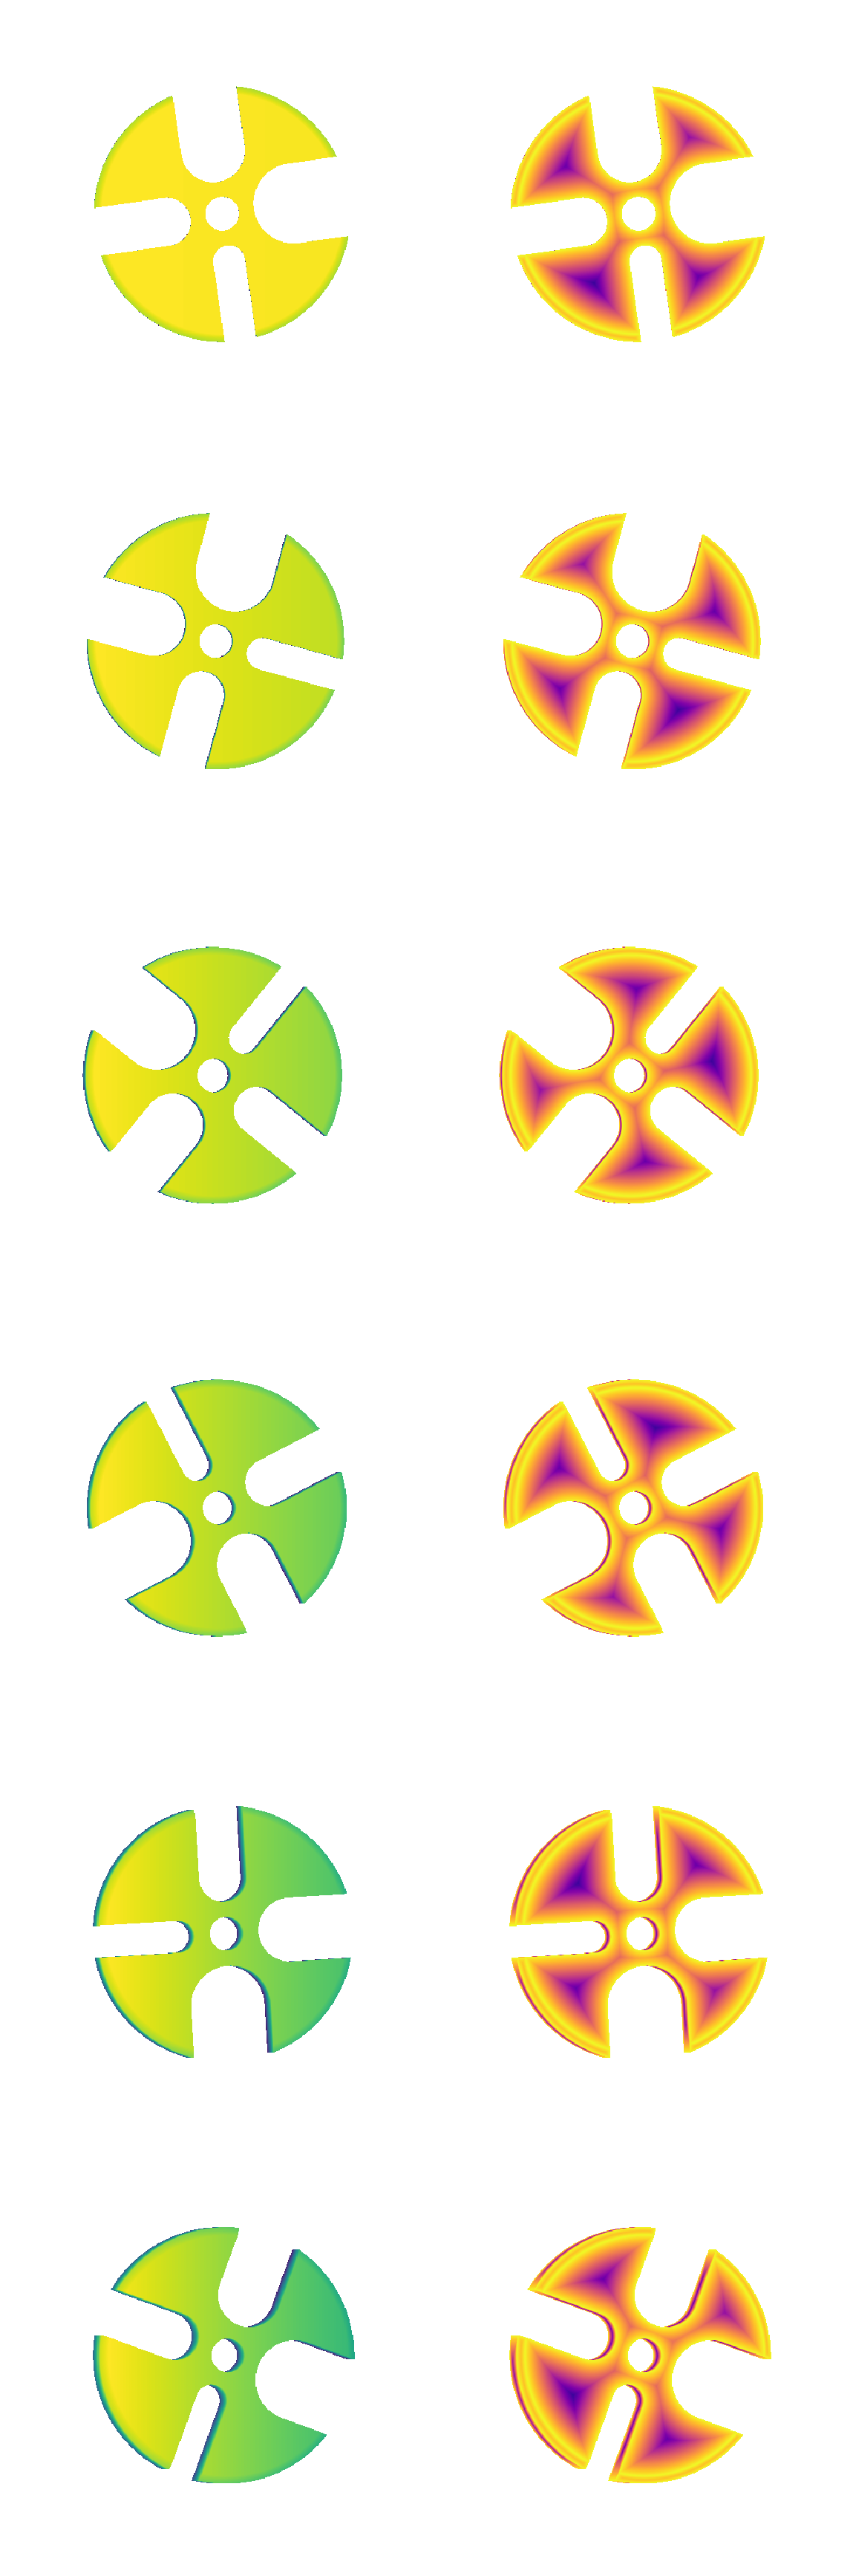

In [13]:
display_depth_sharpness(
    gt_images[:6],
    gt_distances[:6],
    ncols=1
)

In [14]:
pred_distance_scale_ratio = 1.0

predictions_dataset = Hdf5File(
    predictions_filename,
    io=sharpf_io.WholeDepthMapIO,
    preload=PreloadTypes.LAZY,
    labels='*')
pred_distances = [view['distances'] * pred_distance_scale_ratio for view in predictions_dataset]

File /logs/paper_extra/spherical_sphiral/whole_annotation/128_views/abc_0051_64_65__predictions.hdf5 is not compatible with Hdf5File I/O interface <class 'sharpf.utils.abc_utils.hdf5.io_struct.HDF5IO'>
File /logs/paper_extra/spherical_sphiral/whole_annotation/128_views/abc_0051_64_65__predictions.hdf5 is not compatible with Hdf5File I/O interface <class 'sharpf.utils.abc_utils.hdf5.io_struct.HDF5IO'>


In [19]:
depth_images = [camera_to_display(image) for image in gt_images]
sharpness_images_gt = [camera_to_display(image) for image in gt_distances]
sharpness_images_pred = [camera_to_display(image) for image in pred_distances]

sharpness_images = sharpness_images_pred

In [20]:
def prepare_for_display(depth_images, sharpness_images):

    class options:
        crop_size = 'auto'
        depth_bg_value = 0.0
        verbose = False
        center_x = False
        center_y = False
        depth_images = True
        sharpness_images = True
        bg_from_depth = True
        sharpness_bg_value = 0.0



    images = depth_images or sharpness_images
    res_y, res_x = images[0].shape
    center_x, center_y = res_x // 2, res_y // 2
    bg_value = options.depth_bg_value if options.depth_images else options.sharpness_bg_value
    if isinstance(options.crop_size, int):
        bbox = cw_to_tblr(center_x, center_y, options.crop_size, options.crop_size)
    elif isinstance(options.crop_size, str) and options.crop_size == 'full':
        bbox = cw_to_tblr(center_x, center_y, res_x, res_y)
    elif isinstance(options.crop_size, str) and options.crop_size == 'auto':
        bbox = min_bbox_for_all_images(images, bg_value)
    elif isinstance(options.crop_size, str) and options.crop_size == 'auto2k':
        bbox = min_bbox_for_all_images(images, bg_value)
        bbox = snap_bbox_to_2k(bbox)
        bbox = snap_to_image(bbox, res_x, res_y)
    else:
        print('Cannot interpret -c/--crop_size option: "{}"'.format(options.crop_size), file=sys.stderr)
        exit(1)

    if options.verbose:
        print('Bbox size wxh: {} x {}'.format(bbox[3] - bbox[2], bbox[1] - bbox[0]))

    if options.center_x or options.center_y:
        tops, bottoms, lefts, rights = align_to_center_mass(
            images, bg_value, bbox,
            center_x=options.center_x,
            center_y=options.center_y)
        bboxes = [snap_to_image((top, bottom, left, right), res_x, res_y)
                  for top, bottom, left, right in zip(tops, bottoms, lefts, rights)]
        tops, bottoms, lefts, rights = zip(*bboxes)  # unpack list of tuples to tuple of lists

    else:
        top, bottom, left, right = bbox
        n = len(images)
        tops, bottoms, lefts, rights = [top] * n, [bottom] * n, [left] * n, [right] * n

    slices = [(slice(top, bottom), slice(left, right))
              for top, bottom, left, right in zip(tops, bottoms, lefts, rights)]

    depth_images_for_display = None
    if options.depth_images:
        depth_images_for_display = [image[s] for image, s in zip(depth_images, slices)]

    sharpness_images_for_display = None
    if options.sharpness_images:
        sharpness_images_for_display = [distances[s] for distances, s in zip(sharpness_images, slices)]

    if options.depth_images and options.sharpness_images and options.bg_from_depth:
        sharpness_images_for_display = [sharpness_with_depth_background(
            sharpness_image,
            depth_image,
            depth_bg_value=options.depth_bg_value,
            sharpness_bg_value=options.sharpness_bg_value)
            for sharpness_image, depth_image in
            zip(sharpness_images_for_display, depth_images_for_display)]

    return depth_images_for_display, sharpness_images_for_display, slices

In [21]:
depth_images_for_display, sharpness_images_for_display, slices = prepare_for_display(
    depth_images, sharpness_images)

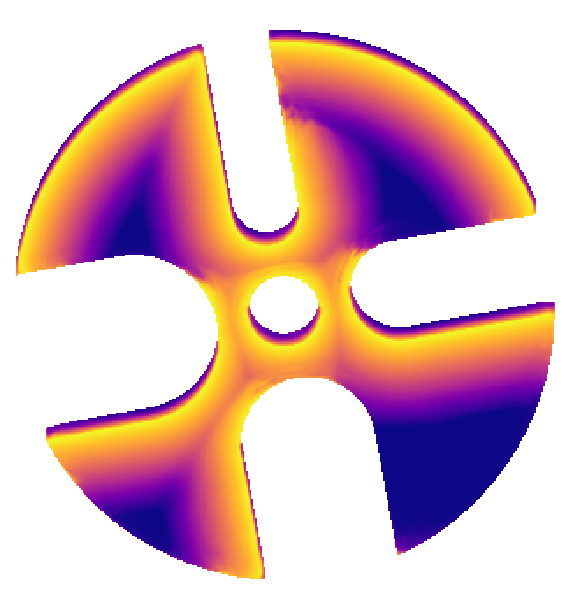

In [22]:
display_depth_sharpness(
#     depth_images=[depth_images_for_display[-5]],
    sharpness_images=[sharpness_images_for_display[-5]],
    ncols=1,
    max_sharpness=1,
#     sharpness_bg_value=10.0
)

In [ ]:
pose_i = CameraPose(gt_extrinsics[-5])
imaging_i = RaycastingImaging(**gt_intrinsics[-5])
points_i = pose_i.camera_to_world(imaging_i.image_to_points(gt_images[-5]))



In [ ]:
annotation_config = {
    "type": "surface_based_aabb",
    "distance_upper_bound": 1.0,
    "always_check_adjacent_surfaces": True,
    "distance_computation_method": 'geom',
}
annotator = load_func_from_config(ANNOTATOR_BY_TYPE, annotation_config)



In [ ]:
from sharpf.utils.abc_utils.abc.abc_data import ABCModality, ABCChunk, ABC_7Z_FILEMASK
from sharpf.utils.abc_utils.mesh.io import trimesh_load


with ABCChunk(['/data/abc/abc_0051_obj_v00.7z', '/data/abc/abc_0051_feat_v00.7z']) as data_holder:
    item = data_holder.get('00515209_339016deab3d8d5c379667e0_000')

mesh, _, _ = trimesh_load(item.obj)
features = yaml.load(item.feat, Loader=yaml.Loader)

In [ ]:
from sharpf.utils.abc_utils.abc import feature_utils


def scale_mesh(mesh, features, shape_fabrication_extent, resolution_3d,
               short_curve_quantile=0.05, n_points_per_short_curve=4):
    # compute standard size spatial extent
    mesh_extent = np.max(mesh.bounding_box.extents)
    mesh = mesh.apply_scale(shape_fabrication_extent / mesh_extent)

    # compute lengths of curves
    sharp_curves_lengths = feature_utils.get_curves_extents(mesh, features)

    least_len = np.quantile(sharp_curves_lengths, short_curve_quantile)
    least_len_mm = resolution_3d * n_points_per_short_curve

    scale = least_len_mm / least_len
    mesh = mesh.apply_scale(scale)

    return mesh, scale

In [ ]:
shape_fabrication_extent = 10.0
base_n_points_per_short_curve = 8
base_resolution_3d = 0.125
short_curve_quantile = 0.25

mesh, mesh_scale = scale_mesh(mesh, features, shape_fabrication_extent, base_resolution_3d,
                              short_curve_quantile=short_curve_quantile,
                              n_points_per_short_curve=base_n_points_per_short_curve)

mesh = mesh.apply_translation(-mesh.vertices.mean(axis=0))

In [ ]:
import igl

In [ ]:
point_mesh_distance, mesh_face_indexes, _ = igl.point_mesh_squared_distance(
    points_i,
    mesh.vertices,
    mesh.faces)
well_aligned_mask = np.sqrt(point_mesh_distance) < 0.02 / 10
aligned_points = points_i[well_aligned_mask]
mesh_face_indexes = mesh_face_indexes[well_aligned_mask]

In [ ]:
imaging_5120 = RaycastingImaging(resolution_image=(5120, 5120), resolution_3d=0.002)
image_5120, points_5120, normals_5120, mesh_face_indexes_5120 = \
    imaging_5120.get_image_from_pose(mesh, pose_i, return_hit_face_indexes=True)

In [ ]:
mesh_face_indexes = np.unique(mesh_face_indexes_5120)

In [ ]:
# nbhood, mesh_vertex_indexes, mesh_face_indexes = \
#             feature_utils.submesh_from_hit_surfaces(mesh, features, mesh_face_indexes)
mesh_vertex_indexes = np.unique(mesh.faces[mesh_face_indexes])
nbhood = reindex_zerobased(mesh, mesh_vertex_indexes, mesh_face_indexes)

# create annotations: condition the features onto the nbhood
nbhood_features = feature_utils.compute_features_nbhood(
    mesh, 
    features, 
    mesh_face_indexes, 
    mesh_vertex_indexes=mesh_vertex_indexes,
    deduce_verts_from_faces=False)

# remove vertices lying on the boundary (sharp edges found in 1 face only)
nbhood_features = feature_utils.remove_boundary_features(
    nbhood,
    nbhood_features, 
    how='edges')

for curve in nbhood_features['curves']:
    curve['vert_indices'] = [v for v in curve['vert_indices'] if v not in [134, 135]]

sharp_vert_indexes = np.concatenate(
    [[v for v in c['vert_indices']]
     for i, c in enumerate(nbhood_features['curves']) if c['sharp']]
)
sharp_vert = nbhood.vertices[sharp_vert_indexes]


display_sharpness(
    nbhood, plot_meshvert=False,
    samples=None, samples_psize=0.01,
    sharp_vert=sharp_vert, sharpvert_psize=0.1
)


In [ ]:
import os
os.environ['OMP_NUM_THREADS'] = '38'

In [ ]:
distances, directions, has_sharp = annotator.annotate(
    nbhood, nbhood_features, aligned_points)

In [ ]:
distances_image = imaging_i.points_to_image(
    distances.reshape(-1, 1), 
    np.where(gt_images[-5].ravel() != 0)[0],
    assign_channels=[0])


In [ ]:
display_depth_sharpness(
#     depth_images=[depth_images_for_display[-5]],
    sharpness_images=[camera_to_display(distances_image)[slices[-5]]],
    ncols=1,
    max_sharpness=1,
#     sharpness_bg_value=10.0
)

In [ ]:
# plt.ioff()

# iterable = zip(depth_images_for_display, sharpness_images_for_display)
# for i, (image, distances) in tqdm(enumerate(iterable), total=len(sharpness_images_for_display)):
#     _ = display_depth_sharpness(
# #         depth_images=[
# #             camera_to_display(image)],
# #         sharpness_images=[
# #             camera_to_display(distances)],
#         depth_images=[image],
#         sharpness_images=[distances],
#         ncols=1,
#         max_sharpness=1.00)
#     _ = plt.savefig('/logs/paper_extra/spherical_sphiral/video-predictions_nobg/{0:04d}.png'.format(i + 1))
#     plt.close()

In [ ]:
def display_resolution(basedir, basename, resolution, index=2):
    
    gt_filename = os.path.join(basedir, '{}__{}.hdf5'.format(basename, resolution))
    
    print('Loading ground truth data...')
    ground_truth_dataset = Hdf5File(
        gt_filename,
        io=sharpf_io.WholeDepthMapIO,
        preload=PreloadTypes.LAZY,
        labels='*')
    gt_dataset = [view for view in ground_truth_dataset]
    # depth images captured from a variety of views around the 3D shape
    gt_images = [view['image'] for view in gt_dataset]
    # ground-truth distances (multi-view consistent for the global 3D shape)
    gt_distances = [view.get('distances', np.ones_like(view['image'])) for view in gt_dataset]

    print('Loading predictions...')
    subdirs = [
        'def-image-arbitrary-regression-high-0.ckpt',
        'def-image-arbitrary-regression-med-0.ckpt',
        'def-image-arbitrary-regression-low-0.ckpt']
    
    pred_distances = [np.load(
        os.path.join(
            basedir, 
            '{}__{}'.format(basename, resolution),
            subdir,
            'predictions',
            'test_{}.npy'.format(index)))
        for subdir in subdirs]

    
    print('Preparing...')
    depth_images = [
        camera_to_display(gt_images[index]),
        camera_to_display(gt_images[index]),
        camera_to_display(gt_images[index]),
        camera_to_display(gt_images[index])
    ]
    sharpness_images = [
        camera_to_display(gt_distances[index]), 
        camera_to_display(pred_distances[0]),
        camera_to_display(pred_distances[1]),
        camera_to_display(pred_distances[2])
    ]

    depth_images_for_display, sharpness_images_for_display = \
        prepare_for_display(depth_images, sharpness_images)
    
    print('Plotting...')
    display_depth_sharpness(
        depth_images=depth_images_for_display[:1],
        sharpness_images=None,
        ncols=1,
        max_sharpness=1,
    #     sharpness_bg_value=10.0
    )

In [ ]:
display_resolution(
    '/logs/paper_extra/resolutions',
    'abc_0051_64_65',
    '0.15',
    index=2
)

In [ ]:
from scipy.interpolate import fitpack
from scipy.spatial import cKDTree
from typing import List, Mapping


def bisplrep_interpolate(xs, ys, vs, xt, yt):
    x_min, x_max = np.amin(xs), np.amax(xs)
    y_min, y_max = np.amin(ys), np.amax(ys)

    out_of_bounds_x = (xt < x_min) | (xt > x_max)
    out_of_bounds_y = (yt < y_min) | (yt > y_max)

    any_out_of_bounds_x = np.any(out_of_bounds_x)
    any_out_of_bounds_y = np.any(out_of_bounds_y)

    if any_out_of_bounds_x or any_out_of_bounds_y:
        raise ValueError("Values out of range; x must be in %r, y in %r"
                         % ((x_min, x_max),
                            (y_min, y_max)))

    tck = fitpack.bisplrep(
        xs.squeeze(),
        ys.squeeze(),
        vs.squeeze(),
        kx=1,
        ky=1,
        s=len(xs.squeeze()))
    vt = fitpack.bisplev(xt, yt, tck)
    return vt


def interp2d_interpolate(xs, ys, vs, xt, yt):
    interpolator = interpolate.interp2d(
        xs.squeeze(),
        ys.squeeze(),
        vs.squeeze(),
        kind='linear',
        bounds_error=True)

    vt = interpolator(xt, yt)[0]
    return vt


def do_interpolate(
        i,
        j,
        view_i,
        view_j,
        point_indexes,
        interp_params,
):
    distance_interpolation_threshold = interp_params['distance_interpolation_threshold']
    nn_set_size = interp_params['nn_set_size']
    verbose = interp_params['verbose']
    interpolator_function = interp_params['interpolator_function']

    image_i, distances_i, points_i, pose_i, imaging_i = view_i
    _, distances_j, points_j, _, _ = view_j

    start_idx, end_idx = (0, point_indexes[j]) if 0 == j \
        else (point_indexes[j - 1], point_indexes[j])
    indexes_j = np.arange(start_idx, end_idx)

    interp_fn = {
        'bisplrep': bisplrep_interpolate,
        'interp2d': interp2d_interpolate,
    }[interpolator_function]

    if i == j:
        predictions_interp, indexes_interp, points_interp = \
            distances_i[image_i != 0.].ravel(), indexes_j, points_i

    else:
        # reproject points from one view j to view i, to be able to interpolate in view i
        reprojected_j = pose_i.world_to_camera(points_j)

        # extract pixel indexes in view i (for each reprojected points),
        # these are source pixels to interpolate from
        uv_i = imaging_i.rays_origins[:, :2]
        _, nn_indexes_in_i = cKDTree(uv_i).query(reprojected_j[:, :2], k=nn_set_size)

        # Create interpolation mask: True for points which
        # can be stably interpolated (i.e. they have K neighbours present
        # within a predefined radius).
        interp_mask = np.zeros(len(reprojected_j)).astype(bool)
        # Distances to be produces as output.
        distances_j_interp = np.zeros(len(points_j), dtype=float)

        for idx, point_from_j in tqdm(enumerate(reprojected_j), desc='Fusing {} -> {}'.format(i, j)):
            point_nn_indexes = nn_indexes_in_i[idx]
            # Build an [n, 3] array of XYZ coordinates for each reprojected point by taking
            # UV values from pixel grid and Z value from depth image.
            point_from_j_nns = np.hstack((
                uv_i[point_nn_indexes],
                np.atleast_2d(image_i.ravel()[point_nn_indexes]).T
            ))

            distances_to_nearest = np.linalg.norm(point_from_j - point_from_j_nns, axis=1)
            interp_mask[idx] = np.all(distances_to_nearest < distance_interpolation_threshold)

            if interp_mask[idx]:
                # Actually perform interpolation
                try:
                    distances_j_interp[idx] = interp_fn(
                        point_from_j_nns[:, 0],
                        point_from_j_nns[:, 1],
                        distances_i.ravel()[point_nn_indexes],
                        point_from_j[0],
                        point_from_j[1]
                    )

                except ValueError as e:
                    if verbose:
                        print('Error while interpolating point {idx}:'
                              '{what}, skipping this point'.format(idx=idx, what=str(e)))
                    interp_mask[idx] = False

                except RuntimeWarning:
                    break

        points_interp = points_j[interp_mask]
        indexes_interp = indexes_j[interp_mask]
        predictions_interp = distances_j_interp[interp_mask]

    return predictions_interp, indexes_interp, points_interp




def multi_view_interpolate_predictions_by_single_view(
        images: List[np.array],
        distances: List[np.array],
        extrinsics: List[np.array],
        intrinsics_dict: List[Mapping],
        **config,
):
    get_view_local = partial(get_view, images, distances, extrinsics, intrinsics_dict)

    point_indexes = np.cumsum([
        np.count_nonzero(image) for image in images])

    n_jobs = config.get('n_jobs')
    n_images = len(images)

    for t in range(n_images):
        start_idx, end_idx = (0, point_indexes[t]) if 0 == t else (point_indexes[t - 1], point_indexes[t])
        indexes = slice(start_idx, end_idx)
        
        view_t = get_view_local(t)
        data_iterable = (
            (s, t, get_view_local(s), view_t, point_indexes, config)
            for s in range(n_images))

        os.environ['OMP_NUM_THREADS'] = str(n_jobs)
        list_predictions, list_indexes_in_whole, list_points = [], [], []
        for predictions_interp, indexes_interp, points_interp in multiproc_parallel(
                do_interpolate,
                data_iterable):
            list_predictions.append(predictions_interp)
            list_indexes_in_whole.append(indexes_interp)
            print(indexes_interp.shape)
            list_points.append(points_interp)

        yield indexes, list_predictions, list_indexes_in_whole, list_points



def get_view(
        images: List[np.array],
        distances: List[np.array],
        extrinsics: List[np.array],
        intrinsics_dict: List[Mapping],
        i):
    """A helper function to conveniently prepare view information."""
    image_i = images[i]  # [h, w]
    distances_image_i = distances[i]  # [h, w]
    # Kill background for nicer visuals
    distances_i = np.zeros_like(distances_image_i)
    distances_i[np.nonzero(image_i)] = distances_image_i[np.nonzero(image_i)]

    pose_i = CameraPose(extrinsics[i])
    imaging_i = RaycastingImaging(**intrinsics_dict[i])
    points_i = pose_i.camera_to_world(imaging_i.image_to_points(image_i))

    return image_i, distances_i, points_i, pose_i, imaging_i


from sharpf.utils.abc_utils.mesh.indexing import in2d

def get_rays_indexes(
    image, 
    imaging
):
    _, rays_indexes = cKDTree(imaging.rays_origins[:, :2], leafsize=1024).query(
        image[:, :2], k=1, n_jobs=4, distance_upper_bound=1e-3)
    return rays_indexes

In [ ]:
PointPatchPredictionsIO = io_struct.HDF5IO(
        {'points': io_struct.Float64('points'),
         'distances': io_struct.Float64('distances')},
        len_label='distances',
        compression='lzf')

In [ ]:
def save_full_model_predictions(points, predictions, filename):
    
    with h5py.File(filename, 'w') as f:
        PointPatchPredictionsIO.write(f, 'points', [points])
        PointPatchPredictionsIO.write(f, 'distances', [predictions])

        
        
combiner = cc.TruncatedAvgPredictionsCombiner(func=cc.TruncatedMean(0.6, func=np.min))

x = []

for t, (indexes, list_predictions, list_indexes_in_whole, list_points) in enumerate(
        multi_view_interpolate_predictions_by_single_view(
        gt_images, pred_distances, gt_extrinsics, gt_intrinsics, **config)):
    print('Obtained view synthesis results for view {}'.format(t))

    print('Fusing predictions...')
    fused_points_pred, fused_distances_pred, prediction_variants = \
        combiner(n_points, list_predictions, list_indexes_in_whole, list_points)

    pred_output_filename = os.path.join(
        '/logs/paper_extra/spherical_sphiral/4_views/',
        '{0}__{1}__view_{2:04d}.hdf5'.format('abc_0051_64_65', combiner.tag, t))
    print('Saving preds to {}'.format(pred_output_filename))
    save_full_model_predictions(
        fused_points_pred[indexes],
        fused_distances_pred[indexes],
        pred_output_filename)
    x.append((indexes, fused_points_pred, fused_distances_pred))


In [ ]:
indexes, fused_points_pred, fused_distances_pred = x[0]

_ = display_sharpness(
    samples=fused_points_pred[indexes],
    samples_distances=fused_distances_pred[indexes], 
    samples_psize=0.02)


In [ ]:
display_depth_sharpness(
#     depth_images=depth_images_for_display[204:205],
    sharpness_images=sharpness_images_for_display,
    ncols=4,
    max_sharpness=1,
#     sharpness_bg_value=10.0
)

In [ ]:
view_index = 1

pose = CameraPose(gt_extrinsics[view_index])
imaging = RaycastingImaging(**gt_intrinsics[view_index])

rays_indexes = get_rays_indexes(
    pose.world_to_camera(fused_points_pred[indexes]),
    imaging)

image = imaging.points_to_image(
    pose.world_to_camera(fused_points_pred[indexes]), 
    rays_indexes)

distances = imaging.points_to_image(
    fused_distances_pred[indexes].reshape(-1, 1), 
    rays_indexes, 
    assign_channels=[0])

In [ ]:
display_depth_sharpness(
    depth_images=[camera_to_display(image)],
    sharpness_images=[camera_to_display(distances)],
    ncols=1,
    max_sharpness=1,
#     sharpness_bg_value=10.0
)

In [ ]:
def get_image_viewwise_interpolation(
    view_filename,
    gt_filename,
    view_index=0,
):  
    PointPatchPredictionsIO = io_struct.HDF5IO(
        {'points': io_struct.Float64('points'),
         'distances': io_struct.Float64('distances')},
        len_label='distances',
        compression='lzf')

    pred_distance_scale_ratio = 1.0

    print(view_filename)
    d = Hdf5File(
        view_filename,
        io=PointPatchPredictionsIO,
        preload=PreloadTypes.LAZY,
        labels='*')
    pred_distances = [view['distances'] * pred_distance_scale_ratio for view in d]
    pred_points = [view['points'] for view in d]

    print(gt_filename)
    d = Hdf5File(
        gt_filename,
        io=sharpf_io.WholeDepthMapIO,
        preload=PreloadTypes.LAZY,
        labels='*')
    gt_extrinsics = [view['camera_pose'] for view in d]
    gt_intrinsics = [dict(
        resolution_image=(512, 512), 
        resolution_3d=resolution_3d, 
        projection=None, 
        validate_image=None) for view in d]
    
    pose = CameraPose(gt_extrinsics[view_index])
    imaging = RaycastingImaging(**gt_intrinsics[view_index])
    
    rays_indexes = get_rays_indexes(
        pose.world_to_camera(pred_points[0]),
        imaging)
    print(rays_indexes)
    
    image = imaging.points_to_image(
        pose.world_to_camera(pred_points[0]), 
        rays_indexes)
    
    distances = imaging.points_to_image(
        pred_distances[0].reshape(-1, 1), 
        rays_indexes, 
        assign_channels=[0])
    
    return image, distances, pred_points[0], pred_distances[0], pose, imaging

In [ ]:
view_index = 7

view_filename = '/logs/paper_extra/spherical_sphiral/whole_annotation/256_views/abc_0051_64_65__adv60__view_{0:04d}.hdf5'.format(view_index)
gt_filename = '/logs/paper_extra/spherical_sphiral/whole_annotation/256_views/abc_0051_64_65__whole_annotation.hdf5'

image, distances, points, points_distances, pose, imaging = get_image_viewwise_interpolation(
    view_filename, 
    gt_filename,
    view_index=view_index)

display_depth_sharpness(
    depth_images=[camera_to_display(image)],
    sharpness_images=[camera_to_display(distances)],
    ncols=1,
    max_sharpness=1,
#     sharpness_bg_value=10.0
)

In [ ]:
view_index = 7

view_filename = '/logs/paper_extra/spherical_sphiral/whole_annotation/256_views/abc_0051_64_65__whole_annotation__adv60__view_{0:04d}.hdf5'.format(view_index)
gt_filename = '/logs/paper_extra/spherical_sphiral/whole_annotation/256_views/abc_0051_64_65__whole_annotation.hdf5'

image, distances, points, points_distances, pose, imaging = get_image_viewwise_interpolation(
    view_filename, 
    gt_filename,
    view_index=view_index)

display_depth_sharpness(
    depth_images=[camera_to_display(image)],
    sharpness_images=[camera_to_display(distances)],
    ncols=1,
    max_sharpness=1,
#     sharpness_bg_value=10.0
)

In [ ]:
# d = Hdf5File(
#     '/logs/paper_extra/spherical_sphiral/whole_annotation/256_views/abc_0051_64_65__adv60.hdf5',
#     io=PointPatchPredictionsIO,
#     preload=PreloadTypes.LAZY,
#     labels=['points', 'distances'])
# pred_distances = [view['distances'] * pred_distance_scale_ratio for view in d]
# pred_points = [view['points'] for view in d]

# d = Hdf5File(
#     '/logs/paper_extra/spherical_sphiral/whole_annotation/256_views/abc_0051_64_65__whole_annotation__ground_truth.hdf5',
#     io=PointPatchPredictionsIO,
#     preload=PreloadTypes.LAZY,
#     labels=['points', 'distances'])
# gt_distances = [view['distances'] * pred_distance_scale_ratio for view in d]

# _ = display_sharpness(
#     samples=pred_points[0],
#     samples_distances=np.abs(pred_distances[0] - gt_distances[0]), 
#     samples_psize=0.02,
#     cmap=k3d.colormaps.matplotlib_color_maps.coolwarm)

In [ ]:
d = Hdf5File(
    '/logs/paper_extra/spherical_sphiral/whole_annotation/128_views/abc_0051_64_65__adv60.hdf5',
    io=PointPatchPredictionsIO,
    preload=PreloadTypes.LAZY,
    labels=['points', 'distances'])
pred_distances = [view['distances'] * pred_distance_scale_ratio for view in d]
pred_points = [view['points'] for view in d]

# d = Hdf5File(
#     '/logs/paper_extra/spherical_sphiral/whole_annotation/256_views/abc_0051_64_65__whole_annotation__ground_truth.hdf5',
#     io=PointPatchPredictionsIO,
#     preload=PreloadTypes.LAZY,
#     labels=['points', 'distances'])
# gt_distances = [view['distances'] * pred_distance_scale_ratio for view in d]

_ = display_sharpness(
    samples=pred_points[0],
    samples_distances=pred_distances[0], 
    samples_psize=0.02,
    cmap=k3d.colormaps.matplotlib_color_maps.coolwarm_r)

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm


class MplColorHelper:

    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgb(self, val):
        return self.scalarMap.to_rgba(val)


    
def export_points_to_npy(
    filename, 
    points, 
    distances=None, 
    pose=None, 
    radius=0.02,
    max_distance=1.0
):
    
    tol = 1e-3
    if distances is None:
        if pose is not None:
            distances = np.linalg.norm(pose.frame_origin - points, axis=1)        
            helper = MplColorHelper(
                'viridis',
                np.min(distances) - tol,
                np.max(distances) + tol)
        else:
            raise ValueError()
    else:
        helper = MplColorHelper(
            'plasma_r',
            -tol,
            max_distance + tol)

    iterable = zip(points, distances)
    colors_rgb = []
    for point, distance in tqdm(iterable):
        rgba = helper.get_rgb(distance)
        colors_rgb.append(rgba[:3])
        
#         point_mesh = trimesh.creation.icosphere(
#             subdivisions=1,
#             radius=radius,
#             color=rgba[:3])
#         point_mesh.vertices += point
#         full_mesh.append(point_mesh)
#     full_mesh = trimesh.util.concatenate(full_mesh)
#     _ = trimesh.exchange.export.export_mesh(
#         full_meshes,
#         'filename',
#         'obj')

    np.save(filename, np.hstack((points, colors_rgb)))
    print('saved {}'.format(filename))
    
    
    
def export_points_to_ply(
    output_filename,
    points,
    distances=None, 
    pose=None, 
    radius=0.02,
    max_distance=1.0
):
    
    tol = 1e-3
    if distances is None:
        if pose is not None:
            distances = np.linalg.norm(pose.frame_origin - points, axis=1)        
            helper = MplColorHelper(
                'viridis',
                np.min(distances) - tol,
                np.max(distances) + tol)
        else:
            raise ValueError()
    else:
        helper = MplColorHelper(
            'plasma_r',
            -tol,
            max_distance + tol)
    
    iterable = zip(points, distances)
    iterable = tqdm(iterable)

    full_mesh = []
    for point, distance in iterable:
        rgba = helper.get_rgb(distance)
        mesh = trimesh.creation.icosphere(
            subdivisions=1,
            radius=radius,
            color=rgba[:3])
        mesh.vertices += point
        full_mesh.append(mesh)

    mesh = trimesh.util.concatenate(full_mesh)
    _ = trimesh.exchange.export.export_mesh(
        mesh,
        output_filename,
        'obj')

    
def get_edges(mesh, features):
    curve_segments = []
    for curve_id, curve in enumerate(features['curves']):
        if curve['sharp']:
            # (n, 2) mask of boolean variables where each variable stores
            # True if the corresponding vertex idx is in curve
            is_edgevert_in_curve = np.isin(mesh.edges_unique, curve['vert_indices'])
            is_edge_in_curve = np.all(is_edgevert_in_curve, axis=1)
            edge_in_curve_indexes = np.where(is_edge_in_curve)[0]
            curve_edges = mesh.edges_unique[edge_in_curve_indexes]  # n_curve, 2
            curve_segment_xyz = mesh.vertices[curve_edges]  # n_curve, 2, 3
            curve_segments.append((curve_id, curve['type'], np.ravel(curve_segment_xyz)))

    return curve_segments


def export_features_to_obj(output_filename, curve_segments):
    with open(output_filename, 'w') as fobj:
        vertices = ''
        indices = ''
        max_vi = 1
        for curve_id, curve_type, xyz_xyz in curve_segments:
            xyz_xyz = xyz_xyz.reshape((-1, 2, 3))
            for v1, v2 in xyz_xyz:
                vertices += 'v {v1}\nv {v2}\n'.format(
                    v1=' '.join([str(coord) for coord in v1]),
                    v2=' '.join([str(coord) for coord in v2])
                )
            for edge_idx, edge in enumerate(xyz_xyz):
                indices += 'l {i1} {i2}\n'.format(
                    i1=str(max_vi + edge_idx * 2),
                    i2=str(max_vi + edge_idx * 2 + 1),
                )
            max_vi += 2 * len(xyz_xyz)
        fobj.write(vertices + '\n' + indices)

In [ ]:
for n in [2, 4, 8, 16, 32, 64, 128]:
    
    d = Hdf5File(
        '/logs/paper_extra/spherical_sphiral/whole_annotation/{}_views/abc_0051_64_65__adv60.hdf5'.format(n),
        io=PointPatchPredictionsIO,
        preload=PreloadTypes.LAZY,
        labels=['points', 'distances'])
    pred_distances = [view['distances'] * pred_distance_scale_ratio for view in d]
    pred_points = [view['points'] for view in d]

    export_points_to_npy(
        '/logs/paper_extra/spherical_sphiral/whole_annotation/fusion__{0:04d}_views.npy'.format(n), 
        pred_points[0], 
        distances=pred_distances[0],
        max_distance=1.0)
    
    print('/logs/paper_extra/spherical_sphiral/whole_annotation/fusion__{0:04d}_views.npy'.format(n))

In [ ]:
get_view_local = partial(get_view, gt_images, pred_distances, gt_extrinsics, gt_intrinsics)

point_indexes = np.cumsum([
    np.count_nonzero(image) for image in gt_images])

In [ ]:
i = 202 + 4
j = 202
view_i = get_view_local(i)
view_j = get_view_local(j)

config = {
    'verbose': True,
    'n_jobs': 8,
    'nn_set_size': 4,
    'distance_interpolation_threshold': 0.2,
    'interpolator_function': 'bisplrep',
}

In [ ]:
predictions_interp, indexes_interp, points_interp = do_interpolate(
    i, j, view_i, view_j, point_indexes, config)
predictions_interp.shape

In [ ]:
pose_j = view_j[3]
imaging_j = view_j[4]

In [ ]:
rays_indexes = get_rays_indexes(
    pose_j.world_to_camera(points_interp),
    imaging_j)

In [ ]:
interpolated_depth_j = imaging_j.points_to_image(
    pose_j.world_to_camera(points_interp), rays_indexes)
interpolated_distances_j = imaging_j.points_to_image(
    predictions_interp.reshape(-1, 1), rays_indexes, assign_channels=[0])

In [ ]:
display_depth_sharpness(
#     depth_images=[camera_to_display(interpolated_j)],
    sharpness_images=[camera_to_display(interpolated_distances_j)[slices[204]]],
    ncols=1,
    max_sharpness=1,
#     sharpness_bg_value=10.0
)

In [ ]:
from sharpf.utils.py_utils.parallel import multiproc_parallel



n_jobs = config.get('n_jobs')
n_images = len(gt_images)
data_iterable = (
    (i, j, get_view_local(i), get_view_local(j), point_indexes, config)
    for i in range(n_images))

os.environ['OMP_NUM_THREADS'] = str(n_jobs)
list_predictions, list_indexes_in_whole, list_points = [], [], []
for predictions_interp, indexes_interp, points_interp in multiproc_parallel(
        do_interpolate,
        data_iterable):
    list_predictions.append(predictions_interp)
    list_indexes_in_whole.append(indexes_interp)
    list_points.append(points_interp)

In [ ]:
import sharpf.fusion.combiners as cc

In [ ]:
combiner = cc.MinPredictionsCombiner()
# combiner = cc.TruncatedAvgPredictionsCombiner(
#            func=cc.TruncatedMean(0.6, func=np.min))

In [ ]:
n_points = np.max(point_indexes)
fused_points_pred, fused_distances_pred, prediction_variants = \
    combiner(n_points, list_predictions, list_indexes_in_whole, list_points)

In [ ]:
rays_indexes = get_rays_indexes(
    pose_j.world_to_camera(fused_points_pred[point_indexes[201]:point_indexes[202]]),
    imaging_j)
interpolated_depth_j = imaging_j.points_to_image(
    pose_j.world_to_camera(fused_points_pred[point_indexes[201]:point_indexes[202]]), rays_indexes)
interpolated_distances_j = imaging_j.points_to_image(
    fused_distances_pred[point_indexes[201]:point_indexes[202]].reshape(-1, 1), 
    rays_indexes, 
    assign_channels=[0])

In [ ]:
display_depth_sharpness(
#     depth_images=[camera_to_display(interpolated_depth_j)[slices[204]]],
    sharpness_images=[camera_to_display(interpolated_distances_j)[slices[204]]],
    ncols=1,
    max_sharpness=1,
#     sharpness_bg_value=10.0
)